Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'

# Decision Trees

## Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website (the URL is in Slack). Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.

## Wrangle Data

**Task 2:** Add to the code below so that `id` is set as the index for `df`.

In [1]:
# IMPORTS

from category_encoders import OneHotEncoder, OrdinalEncoder
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
import plotly.express as px 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns


In [2]:

# df = pd.merge(pd.read_csv(DATA_PATH + 'waterpumps/train_features.csv'),
#               pd.read_csv(DATA_PATH + 'waterpumps/train_labels.csv'))
# # YOUR CODE HERE
# raise NotImplementedError()

pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

def wrangle(fm_data, tv_data=None):
    """Merges features and labels for training-data. Wrangles data for training 
    and test features. Returns wrangled DataFrame."""

    DATA_PATH = '../data/ds24-water-pump-challenge/'

    if tv_data:
        df = pd.merge(pd.read_csv(DATA_PATH + fm_data, na_values=[0, -2.0e-08]),
                    pd.read_csv(DATA_PATH + tv_data)).set_index('id')

    else:
        df = pd.read_csv(DATA_PATH + fm_data).set_index('id')

    # Drop constant and repeated columns
    df.drop(columns=['recorded_by', 'extraction_type_group', 'quantity_group'], 
          inplace=True)
  
    # Fill 'construction_year' NaN values with the mode
    df['construction_year'].fillna(value=df['construction_year'].mode()[0], inplace=True)
    df['construction_year'] = df['construction_year'].astype(int)

    # Change 'date_recorded' to_datetime objects, extract the year and convert to integer
    df['date_recorded'] = pd.to_datetime(df['date_recorded'], infer_datetime_format=True)
    df['date_recorded'] = df['date_recorded'].dt.year
    df['date_recorded'] = df['date_recorded'].astype(int)

    # Create new column indicating date_recorded is 2013 for all pumps 
    #df['needs_to_repair'] = df['status_group'].apply(lambda x : 0 if x == 'functional' else 1)
    #df['updated_date_recorded'] = df['date_recorded'].apply(lambda x: int(2013))
    df['new_date_recorded'] = [int(2013)] * len(df['date_recorded'])
    
    # Create feature documenting number of years pump has been in service
    df['pump_years'] = df['new_date_recorded'] - df['construction_year']
    df.loc[df['pump_years'] == 2013, 'pump_years'] = np.nan
    
    # Drop high-cardinality columns:
    high_cardinality = [col for col in df.select_dtypes('object').columns
                        if df[col].nunique() > 100]
    df.drop(columns=high_cardinality, inplace=True)

    # Drop columns with high % of NaN values, as well as date features aside from 'pump years'
    df.drop(labels=['amount_tsh', 'num_private', 'date_recorded', 'construction_year', 'new_date_recorded', 'district_code', 'region_code'],
            axis=1, 
            inplace=True) # Consider dropping 'source_class'

    # Return wrangled DataFrame                                                                           
    return df

df = wrangle(fm_data='train_features.csv', tv_data='train_labels.csv')
X_test = wrangle(fm_data='test_features.csv')

print(df.shape, X_test.shape)
df.head()

(59399, 25) (14358, 24)


,gps_height,longitude,latitude,basin,region,population,public_meeting,scheme_management,permit,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pump_years
id,,,,,,,,,,,,,,,,,,,,,,,,,
69572.0,1390.0,34.938093,-9.856322,Lake Nyasa,Iringa,109.0,True,VWC,False,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,14.0
8776.0,1399.0,34.698766,-2.147466,Lake Victoria,Mara,280.0,NaN,Other,True,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3.0
34310.0,686.0,37.460664,-3.821329,Pangani,Manyara,250.0,True,VWC,True,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,4.0
67743.0,263.0,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,58.0,True,VWC,True,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,27.0
19728.0,NaN,31.130847,-1.825359,Lake Victoria,Kagera,NaN,True,NaN,True,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3.0


In [3]:
#print(df['construction_year'].mode()[0], "\n")
print(X_test.info())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14358 entries, 50785 to 68707
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gps_height             14358 non-null  int64  
 1   longitude              14358 non-null  float64
 2   latitude               14358 non-null  float64
 3   basin                  14358 non-null  object 
 4   region                 14358 non-null  object 
 5   population             14358 non-null  int64  
 6   public_meeting         13573 non-null  object 
 7   scheme_management      13419 non-null  object 
 8   permit                 13695 non-null  object 
 9   extraction_type        14358 non-null  object 
 10  extraction_type_class  14358 non-null  object 
 11  management             14358 non-null  object 
 12  management_group       14358 non-null  object 
 13  payment                14358 non-null  object 
 14  payment_type           14358 non-null  object 
 15

In [93]:
cols = df.select_dtypes('number').columns
df[cols].nunique()

gps_height     2427
longitude     57514
latitude      57515
population     1048
pump_years       54
dtype: int64

In [6]:
set(df.columns).difference(set(X_test.columns))

{'status_group'}

In [94]:
df.head(20).T.duplicated()

gps_height               False
longitude                False
latitude                 False
basin                    False
region                   False
population               False
public_meeting           False
scheme_management        False
permit                   False
extraction_type          False
extraction_type_class    False
management               False
management_group         False
payment                  False
payment_type             False
water_quality            False
quality_group            False
quantity                 False
source                   False
source_type              False
source_class             False
waterpoint_type          False
waterpoint_type_group    False
status_group             False
pump_years               False
dtype: bool

In [95]:
df['pump_years'].value_counts() # < 0 
X_test['pump_years'].value_counts(dropna=False) # < 0 and > 2_000

NaN     5024
3.0      649
4.0      646
5.0      617
13.0     473
7.0      412
6.0      356
2.0      318
10.0     283
9.0      280
18.0     266
11.0     264
8.0      259
1.0      245
14.0     243
35.0     230
28.0     228
23.0     214
17.0     207
15.0     205
19.0     200
29.0     186
33.0     186
41.0     180
31.0     178
16.0     175
21.0     163
12.0     138
25.0     136
39.0     133
20.0     132
38.0     124
27.0     119
37.0     111
30.0     106
22.0      82
43.0      81
24.0      80
26.0      68
34.0      51
32.0      45
36.0      44
40.0      38
42.0      32
0.0       32
50.0      22
53.0      22
46.0      18
44.0      17
45.0      16
49.0       8
52.0       7
51.0       5
47.0       2
48.0       2
Name: pump_years, dtype: int64

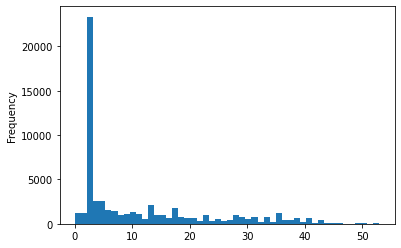

In [96]:
df['pump_years'].plot(kind='hist', bins=50)
plt.show()

In [10]:
checker = df[df['pump_years'] < 0]
checker

,gps_height,longitude,latitude,basin,region,population,public_meeting,scheme_management,permit,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pump_years
id,,,,,,,,,,,,,,,,,,,,,,,,,


**Test 2**

In [27]:
'''Task 2 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created the DataFrame `df`?'
assert df.shape == (59399, 40), '`df` is the wrong shape. Did you set the index to `id`?'
assert 69572 in df.index, 'The index for `df` is has the wrong values. Did you set the index to `id`?'

## Split Data

**Task 3:** Create your target vector `y` and feature matrix `X`.

In [3]:
target = 'status_group'

y = df[target]
X = df.drop(columns=target)

print(X.shape, y.shape)

(59399, 24) (59399,)


**Test 3**

In [ ]:
'''Task 3 Testing'''

assert isinstance(X, pd.DataFrame), '`X` is the wrong data type.'
assert isinstance(y, pd.Series), '`y` is the wrong data type.'
assert y.shape == (59400,), '`y` is the wrong shape.'
assert X.shape == (59400,39), '`X` is the wrong shape.'

We already have a test set for this model, the `test.csv` that you'll use to make the predictions you'll upload to Kaggle. However, since our competition only allows for 2 submissions per day, we need a way to estimate our training error so that we can quickly iterate and improve our model. We can achieve this by creating a validation set from the data we have.

**Task 4:** Split `X` and `y` into training and validation sets. Your validation set should be 20% of the data you have. You should have four variables: `X_train`, `X_val`, `y_train`, and `y_val`. 

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(47519, 24) (47519,) (11880, 24) (11880,)


**Test 4**

In [ ]:
'''Task 4 Testing'''

assert X_train.shape == (47520, 39), '`X_train` is the wrong shape.'
assert X_val.shape == (11880, 39), '`X_val` is the wrong shape.'
assert y_train.shape == (47520,), '`y_train` is the wrong shape.'
assert y_val.shape == (11880,), '`y_val` is the wrong shape.'

## Establish Baseline

**Task 5:** This is a **classification** problem, so you need to establish the baseline accuracy for your training set. Find the majority class for `y_train` and calculate the percentage of labels in `y_train` belonging to that class. Assign your answer to the variable name `baseline_acc`.

In [88]:
baseline_acc = y_train.value_counts(normalize=True)[0]

print(f'Baseline Accuracy: {baseline_acc*100:.4f}%')

Baseline Accuracy: 54.2583%


**Task 5**

In [ ]:
'''Task 5 Testing'''

assert isinstance(baseline_acc, float), '`baseline_acc` should be a `float`.'
assert 0.0 <= baseline_acc <= 1.0, '`baseline_acc` is a score that should be between 0 and 1.'

## Build Model

**Task 6:** Create a model named `model` and train it with your training data. Your model should be a pipeline with (a) transformers that you think are appropriate to this dataset and (b) a `DecisionTreeClassifier` as your predictor. **Tip:** How can you transform categorical features and missing values in order to train your model?

In [14]:
# Decision Tree Classifier
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, max_leaf_nodes=None, 
                           random_state=42),
)

model.fit(X_train, y_train);

In [99]:
# Random Forest Classifier
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'), # Submit with 'median' and 'most_frequent'
    RandomForestClassifier(n_estimators=80,
                           max_depth=21,
                           max_features='auto', 
                           max_leaf_nodes=None,
                           random_state=22
                           ),
)

model_rf.fit(X_train, y_train);

# model_rf = make_pipeline(
#     OrdinalEncoder(),
#     SimpleImputer(strategy='median'), # Submit with 'median' and 'most_frequent'
#     RandomForestClassifier(n_estimators=80,
#                            max_depth=21,
#                            max_features=10, 
#                            max_leaf_nodes=None,
#                            random_state=22
#                            ),
# )

# model_rf.fit(X_train, y_train);

**Test 6**

In [239]:
'''Task 6 Testing'''

assert len(model) > 1, 'Your model pipeline should have multiple steps.'
assert isinstance(model[-1], DecisionTreeClassifier), 'Your pipline should end in a `DecisionTreeClassifier`.'
assert hasattr(model, 'classes_'), 'Have you fit your model?'

## Check Metrics

**Task 7:** Calculate the training and validation accuracy of your model, and assign them to the valiables `training_acc` and `validation_acc`, respectively. Your validation accuracy should be greater than your baseline accuracy.

In [16]:
training_acc = model.score(X_train, y_train)
validation_acc = model.score(X_val, y_val)

print(f'Training Accuracy (Decision Tree): {training_acc*100:.4f}%')
print(f'Validation Accuracy (Decision Tree): {validation_acc*100:.4f}%')

Training Accuracy (Decision Tree): 77.6447%
Validation Accuracy (Decision Tree): 75.3620%


In [100]:
training_acc = model_rf.score(X_train, y_train)
validation_acc = model_rf.score(X_val, y_val)

print(f'Training Accuracy (Random Forest): {training_acc*100:.4f}%')
print(f'Validation Accuracy (Random Forest): {validation_acc*100:.4f}%')

# initial tune, training - 95.103
# initial tune, accuracy - 80.8165

Training Accuracy (Random Forest): 95.1030%
Validation Accuracy (Random Forest): 80.8165%


**Test 7**

In [241]:
'''Task 7 Testing'''

assert isinstance(training_acc, float)
assert isinstance(validation_acc, float)
assert 0.0 <= training_acc <= 1.0
assert 0.0 <= validation_acc <= 1.0

## Create Kaggle Submission

**Task 8:** Load `'waterpumps/test.csv'` into a DataFrame named `X_test`. Generate a list of predictions, and then put them into a DataFrame `submission`. Be sure that `submission` has the same index as `X_test` and that the column name for your predictions is `'status_group'`.  

In [168]:
# X_test = pd.read_csv(DATA_PATH + 'waterpumps/test_features.csv', index_col='id')
# # YOUR CODE HERE
# raise NotImplementedError()

submission = model_rs.predict(X_test)
idx = X_test.index
submission = pd.DataFrame({'status_group' : submission}, index=idx)

submission.head()

,status_group
id,
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional


**Test 8**

In [243]:
'''Task 8 Testing'''

assert isinstance(submission, pd.DataFrame), '`submission` should be a DataFrame.'
assert len(submission) == 14358, '`submission` should have 14358 rows.'

**Task 9 (`stretch goal`):** Save `submission` as a csv file using [`.to_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) and submit it to our Kaggle competition.

In [169]:
#submission.to_csv(DATA_PATH + 'submission.csv')

submission.to_csv('../data/ds24-water-pump-challenge/submission_2_17_2021_b.csv')

## Explain

**Task 10 (`stretch goal`):** Make a horizontal barchart of the 10 most important features for your model.

<AxesSubplot:>

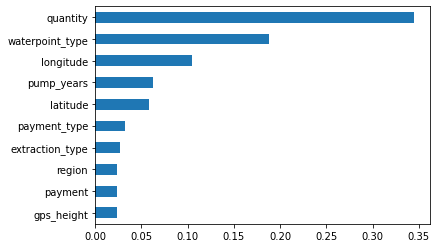

In [19]:
# Decision Tree Feature Importances
importances = model.named_steps['decisiontreeclassifier'].feature_importances_
feature_names = model.named_steps['ordinalencoder'].get_feature_names()

pd.Series(importances, index=feature_names).sort_values().tail(10).plot(kind='barh')

In [20]:
# Decision Tree Hyperparameter Tuning
depths = range(2,32,2)
train_acc = []
val_acc = []

for depth in depths:
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      DecisionTreeClassifier(max_depth=depth, random_state=42)
  )

  tree_model.fit(X_train, y_train)

  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

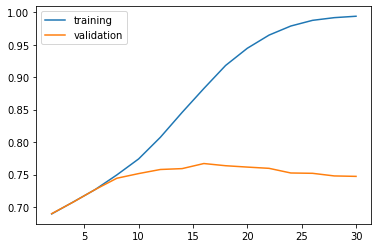

In [21]:
plt.plot(depths, train_acc, label='training')
plt.plot(depths, val_acc, label='validation')

plt.xlabel=('depths')
plt.ylabel=('accuracy')
plt.legend()
plt.show()

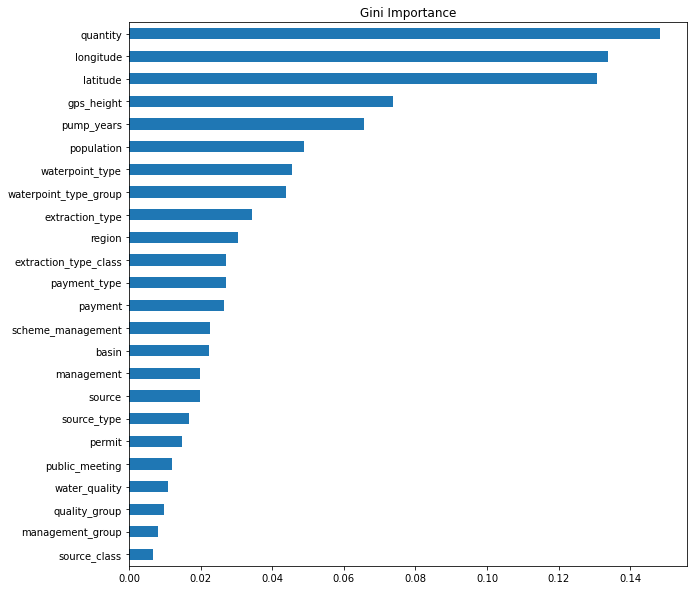

In [65]:
# Random Forest Classifier Feature Importances
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
feature_names = model_rf.named_steps['ordinalencoder'].get_feature_names()
feature_importances = pd.Series(importances, index=feature_names).sort_values()
plt.figure(figsize=(10,10))
ax = feature_importances.plot(kind='barh', title='Gini Importance')

In [60]:
# Random Forest Hyperparameter Tuning
n_ests = range(10,151,10) # Best about 80
depths = range(2,32,2) # Best about 21
feats = ('sqrt', 'log2', 10) # 'sqrt' == 'auto', no change
max_leaves = range(5,156,10) # None == best performance, no change

train_acc = []
val_acc = []

for depth in depths:
    ensemble_model = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(),
        RandomForestClassifier(n_estimators=100,
                               max_depth=depth,
                               max_features='auto', 
                               max_leaf_nodes=None,
                               random_state=22)
    )
    
    ensemble_model.fit(X_train, y_train)

    train_acc.append(ensemble_model.score(X_train, y_train))
    val_acc.append(ensemble_model.score(X_val, y_val))

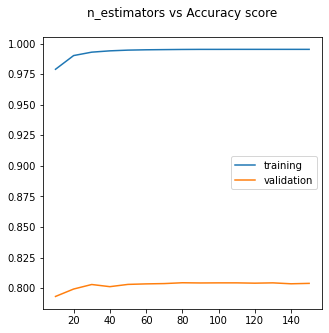

In [47]:
# Number of estimators and accuracy scores

fig, ax = plt.subplots(figsize=(5,5))

ax.plot(n_ests, train_acc, label='training')
ax.plot(n_ests, val_acc, label='validation')
ax.set_title('n_estimators vs Accuracy score', pad=20)
ax.legend()
plt.show()

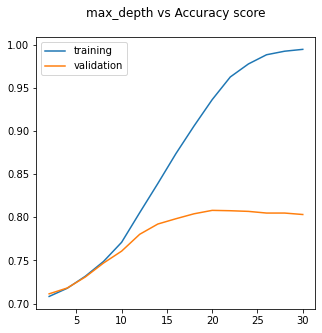

In [62]:
# Depth vs accuracy scores

fig, ax = plt.subplots(figsize=(5,5))

ax.plot(depths, train_acc, label='training')
ax.plot(depths, val_acc, label='validation')
ax.set_title('max_depth vs Accuracy score', pad=20)
ax.legend()
plt.show()

In [49]:
# max_features ('sqrt', 'log2', 10)

print(train_acc)
print(val_acc)

[0.9952229634462004, 0.9952229634462004, 0.9952440076600939]
[0.8042929292929293, 0.8042929292929293, 0.8026936026936027]


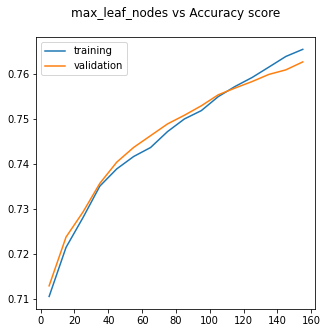

In [59]:
# max_leaf_nodes vs accuracy scores

fig, ax = plt.subplots(figsize=(5,5))

ax.plot(max_leaves, train_acc, label='training')
ax.plot(max_leaves, val_acc, label='validation')
ax.set_title('max_leaf_nodes vs Accuracy score', pad=20)
ax.legend()
plt.show()

In [161]:
# Search for best hyperparameter tuning using RandomizedSearchCV (Bayes too???)

estimator = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=22)
)

params = {'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
          'randomforestclassifier__n_estimators': range(50,201,10),
          'randomforestclassifier__max_depth': range(5,51,5),
          'randomforestclassifier__max_features': ('sqrt', 'log2', 5, 10, 15, 20),
          }

model_rs = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=50,
    n_jobs=-1,
    cv=5,
    verbose=1
)

model_rs.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=22))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 51, 5),
                                        'randomforestclassifier__max_features': ('sqrt',
                                                                                 'log2',
                                                                                 5,
                                                                                 10,
                                                                                 15,
                                    

In [162]:
model_rs.best_score_

0.8086668137728832

In [150]:
model_rs.best_estimator_

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'waterpoint_type',
                                      'waterpoint_type_group'],
                                mapping=[{'col': 'basin',...
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                  

In [163]:
model_rs.best_params_

{'simpleimputer__strategy': 'median',
 'randomforestclassifier__n_estimators': 190,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__max_depth': 20}

In [164]:
# Save the model to disk
filename = 'model_rs.pkl'
joblib.dump(model_rs, filename)

['model_rs.pkl']

In [167]:
model_rs.score(X_val, y_val)

0.9343434343434344

In [6]:
estimator = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=22)
)

params = {'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
          'randomforestclassifier__n_estimators': range(50,201,10),
          'randomforestclassifier__max_depth': range(5,51,5),
          'randomforestclassifier__max_features': ('sqrt', 'log2', 5, 10, 15, 20),
          }

model_bs = BayesSearchCV(
    estimator,
    search_spaces=params,
    n_iter=5,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model_bs.fit(X, y);

ValueError: Dimension has to be a list or tuple.